In [ ]:
import jax
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_enable_x64", True)
from jax import grad, jit, vmap
from jax import random
import jax.numpy as jnp
from jax.experimental.ode import odeint

from functools import partial
import itertools

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm as tq
import seaborn as sb

$\newcommand{\mat}[1]{{\mathbf{{{#1}}}}}$


## Mathematics of model
The are a set of $M$ patterns, or memories, of dimension $N$. These patterns are complex valued with magnitude 1 and descrete phases, i.e.

$$\xi^k = e^{2\pi i \mat{q}^k} \in \mathbb{C}^N, \forall k \in \{ 1,...,M\}$$

The phases take on $Q$ discrete states,
$$q_i^k \in \{0,...,Q-1\}$$

We would like to have a model that can has a **distributed** memory and can retrieve noisy versions of the patterns.

Turns out that an energy function can be constructed such that this is acheived by moving to stable fixed points in the complex space. This energy function looks like:

$$E= \frac{1}{2}\mat{z}^{*T}\mat{W}\mat{z}$$

where the Hebbian weight matrix, $\mat{W}$, is computed via:

$$\mat{W} = \frac{1}{m}\sum_{k=1}^m \xi^k\xi^{k*T}$$

and $\mat{z}$ is the query (a noisy version of something in $\{\xi_1,...,\xi_M\}$). Dynamics are defines as an activation function, $f(\circ)$, over the inner product of the weights and current query, i.e.

$${z_i}(t+1) = f(\sum_j W_{ij}z_j(t))$$

The activation function quantizes the phase of the preactivation potential, $u_i$, to one of the $Q$ discrete states,

$$f(u_i) = \text{exp}(\frac{2\pi i}{Q}\arg\min_{q}|\phi_i^u - \frac{2\pi q}{Q}|)$$


System of ordinary differential equations (ODE) is as follows.
$$\frac{\partial \phi_i}{\partial t} = - \epsilon \sum_{i\neq j}R_{ij} \sin\left(\phi_i - \phi_j - \Phi_{ij}\right) -  h \sin\left( \omega \phi_i \right)$$


# An oscillator based resonator
We provide an example oscillator based resonator network with three factors.

Given memory matrices $W^{(x)}$,  $W^{(y)}$,  and $W^{(z)}$. The dynamics of the oscillator based resonator are


$$\tau\frac{d \phi_i^{(x)}} {dt} = \sum_j R_{ij}^{(x)} \sin(\phi_j^{(x)} + \Phi_{ij}^{(x)} - (\phi_i^{(s)} - \phi_i^{(y)} - \phi_i^{(z)} ))$$
$$\tau\frac{d \phi_i^{(y)}} {dt} = \sum_j R_{ij}^{(y)} \sin(\phi_j^{(y)} + \Phi_{ij}^{(y)} - (\phi_i^{(s)} - \phi_i^{(x)} - \phi_i^{(z)} ))$$

$$\tau\frac{d \phi_i^{(z)}} {dt} = \sum_j R_{ij}^{(z)} \sin(\phi_j^{(z)} + \Phi_{ij}^{(z)} - (\phi_i^{(s)} - \phi_i^{(x)} - \phi_i^{(y)} )) - h\sin(Q\phi_i^{(z)})$$

<!-- $$\tau\frac{d \phi_i^{(s)}} {dt} = \sin(\phi_i^{(x)} + \phi_i^{(y)} +\phi_i^{(z)} - \phi_{i}^{(s)} )$$ -->

Where $R_{ij}^{(k)} = |w_{ij}^{(k)}|$ and $\Phi_{ij}^{(k)} = \text{arg}(w_{ij}^{(k)})$.

In [ ]:
def random_q_state(num_patterns, num_neurons, num_states, key):
    '''
    generate random patterns for memory
    ---
    parameters:
    num_patterns - scalar (1,)
        number of patterns to generate
    num_neurons - scalar (1,)
        number of neurons (dimension of each pattern)
    num_states - scalar (1,)
        number of discrete phase states (Q)
    key - scalar (1,)
        key for jax PRNG
    ---
    returns:
    complex - (num_patterns, num_neurons)
        phasor memory of patterns
    '''
    x = random.randint(key, shape=(num_patterns, num_neurons), minval=0, maxval=num_states)
    return jnp.exp(1j * 2 * jnp.pi * x / num_states)


@jit
def similarity(S, z):
    '''
    Compute the similarity between patterns in S and query z
    ---
    parameters:
    S - complex (num_patterns, num_neurons)
        patterns stored in model
    z - complex (num_neurons,)
        query
    ---
    returns:
    complex (num_patterns,)
        similarity between z and each pattern in S
    '''
    return jnp.abs(S.dot(z.conj())) / (jnp.linalg.norm(z) * jnp.linalg.norm(S, axis=1) + 10**-12)


@jit
def outer_learning(S):
    '''
    Hebbian outer product learning rule, computes weight matrix
    ---
    parameters:
    S - complex (num_patterns, num_neurons)
        patterns stored in model
    ---
    returns:
    complex (num_neurons, num_neurons)
        weight matrix
    '''
    return S.T @ S.conj() / S.shape[0] - jnp.eye(S.shape[1])


# @jit
def phase_dynamics(phis, t, s_phi, Ws, Q, c, h):
  num_factors = len(phis)
  dphis = []
  phi_diffs = s_phi - jnp.sum(phis, axis=0)
  for i in range(num_factors):
    x_phi = phis[i]
    dphi = phi_diffs + x_phi
    dphi = c * jnp.sum(jnp.abs(Ws[i]) * jnp.sin(+dphi[None,  :] + jnp.angle(Ws[i]) - x_phi[:, None]), axis=-1)
    dphi = dphi - h * jnp.sin(Q * x_phi)
    dphis.append(dphi)
  return jnp.array(dphis)


In [ ]:
key = random.PRNGKey(1)

num_factors = 2
num_neurons  = 1000
num_patterns = int(.5 * num_neurons)
num_states = 3

c = 0.1
h = .0


num_cycles = 2**8
t_end = 2 * jnp.pi * num_cycles
t0 = 0
times = jnp.linspace(t0, t_end, 50)

key, subkey = random.split(key)

Ss = []
Ws = []
for i in range(num_factors):
  key, subkey = random.split(key, 2)
  S = random_q_state(num_patterns, num_neurons, num_states, subkey)
  Ss.append(S)
  Ws.append(outer_learning(S))
Ss = jnp.stack(Ss)
Ws = jnp.stack(Ws)

s_phi = jnp.angle(jnp.exp(1j * jnp.sum(jnp.angle(Ss[:, 0]), axis=0)))

def f(x, t):
    return phase_dynamics(x, t, s_phi=s_phi, Ws=Ws, Q=num_states, c=c, h=h)


phi_inits = []
for i in range(num_factors):
  key, subkey1 = random.split(key, 2)
  phi_inits.append(2 * jnp.pi * random.uniform(subkey1, shape=(num_neurons, )))
  # phi_inits.append(jnp.angle(Ss[i, 0]))
phi_inits = jnp.stack(phi_inits)
sol = odeint(f, phi_inits, times)



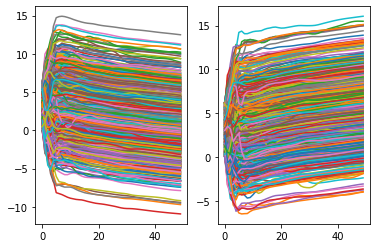

In [ ]:
fig, axs = plt.subplots(1, num_factors)
if num_factors == 1:
    axs.plot(sol[:, i, :])
else:
  for i in range(num_factors):
    axs[i].plot(sol[:, i, :])


In [ ]:
sims = []
for i in range(num_patterns):
  sims.append(jnp.array([similarity(Ss[i], jnp.exp(1j * s[i])) for s in sol]))
sims = jnp.array(sims)

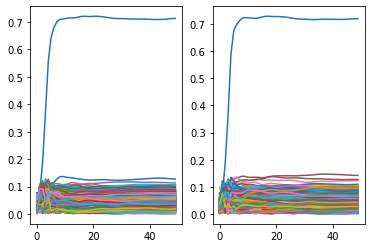

In [ ]:
fig, axs = plt.subplots(1, num_factors)
if num_factors == 1:
  axs.plot(sims[i, :, :])
else:
  for i in range(num_factors):
    axs[i].plot(sims[i, :, :])